In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import joblib

# Ler os dados em formato bruto

In [2]:
data = 'ndt'
df = pd.read_csv(f'datasets/dados_{data}.csv')
df['DataHora'] = pd.to_datetime(df['DataHora'])

# Excluindo os clientes com poucas medições
df = df[(df['ClientMac'] != 'dca6326b9aa1') & (df['ClientMac'] != 'dca6326b9ada') & (df['ClientMac'] != 'e45f018e527a')]
df = df.dropna(subset=['ClientMac'])

In [3]:
from timeseries_processing import map_mac_to_client

# Criar mapeamento de ClientMac para ID
df, mapping_dict = map_mac_to_client(df)

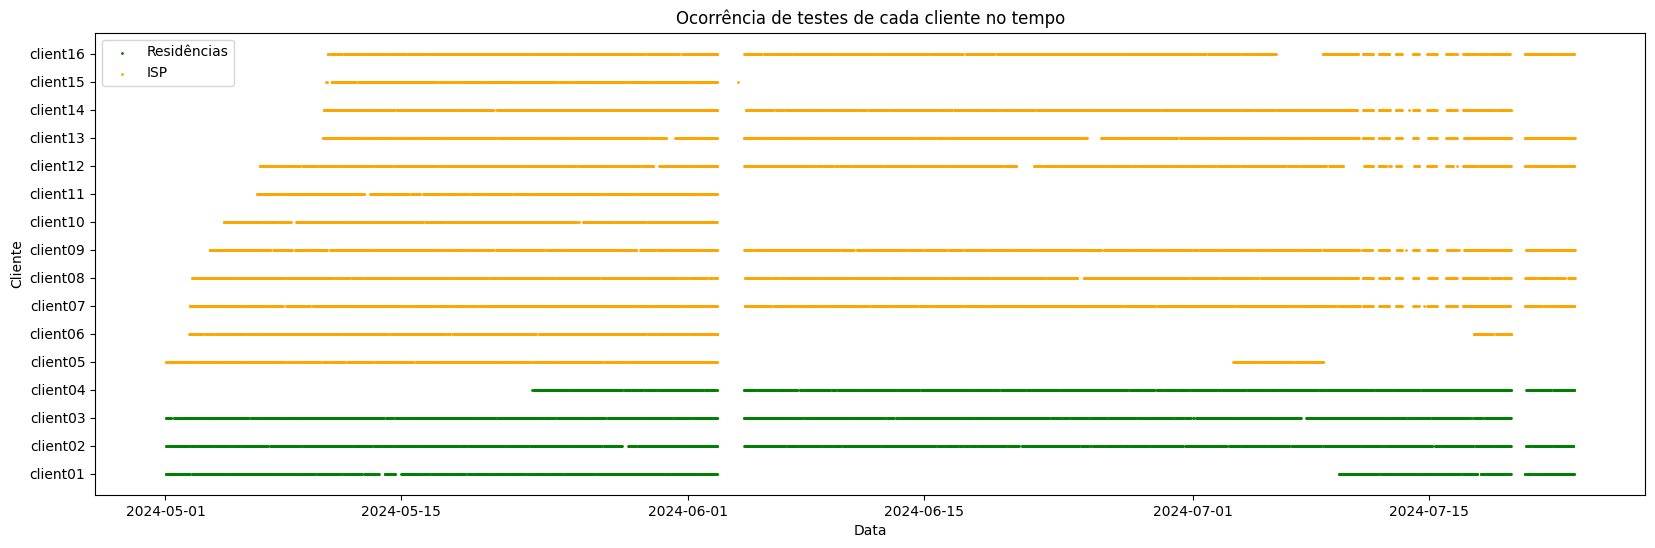

In [4]:
# Plotar a ocorrência de medições no tempo
df_grouped = df.groupby(['ClientId', 'DataHora']).size().reset_index(name='count')

plt.figure(figsize=(20, 6))

# Plotar os clientes voluntários em uma cor diferente
volunt_clients = ['client01', 'client02', 'client03', 'client04']

volunt_df = df_grouped[df_grouped['ClientId'].isin(volunt_clients)]
non_volunt_df = df_grouped[~df_grouped['ClientId'].isin(volunt_clients)]


plt.scatter(volunt_df['DataHora'], volunt_df['ClientId'], s=1, label='Residências', color='green')
plt.scatter(non_volunt_df['DataHora'], non_volunt_df['ClientId'], s=1, label='ISP', color='orange')

plt.xlabel('Data')
plt.ylabel('Cliente')
plt.title('Ocorrência de testes de cada cliente no tempo')
plt.legend()
plt.savefig(f'imgs/medicoes_no_tempo.png')
plt.show()

In [5]:
df.to_parquet(f'datasets/dados_{data}.parquet')

# Exportar as séries temporais dos dados

In [6]:
from timeseries_processing import export_time_series

# Exporta as séries temporais
df_ts = export_time_series(data)

In [7]:
df_ts['client'].unique()

array(['client05', 'client01', 'client03', 'client02', 'client06',
       'client07', 'client08', 'client09', 'client10', 'client11',
       'client12', 'client13', 'client14', 'client15', 'client16',
       'client04'], dtype=object)

In [8]:
df_ts['site'].unique()

array(['gru03', 'rnp_sp', 'rnp_rj', 'gru05', 'gru06'], dtype=object)

# Rodar o VWCD para detectar os pontos de mudança

In [9]:
from timeseries_processing import detect_changepoints

# Configuração dos hiperparâmetros do VWCD
wv = 20                  # Tamanho da janela deslizante
ab = 1                   # Hiperparâmetros Alfa e Beta da beta-binomial - distribuição a priori da janela
p_thr = 0.8              # Limiar de probabilidade para o voto de uma janela ser registrado
vote_p_thr = 0.9         # Limiar de probabilidade para definir um ponto de mudança após a agregação dos votos
vote_n_thr = 0.5         # Fração mínima da janela que precisa votar para definir um ponto de mudança após a agregação
y0 = 0.5                 # Probabilidade a priori da função logística (início da janela)
yw = 0.9                 # Probabilidade a priori da função logística (início da janela)
aggreg = 'mean'          # Função de agregação dos votos

# Detectar pontos de mudança nas séries temporais
#detect_changepoints(data, wv, ab, p_thr, vote_p_thr, vote_n_thr, y0, yw, aggreg)

## Plotar métricas de exemplo

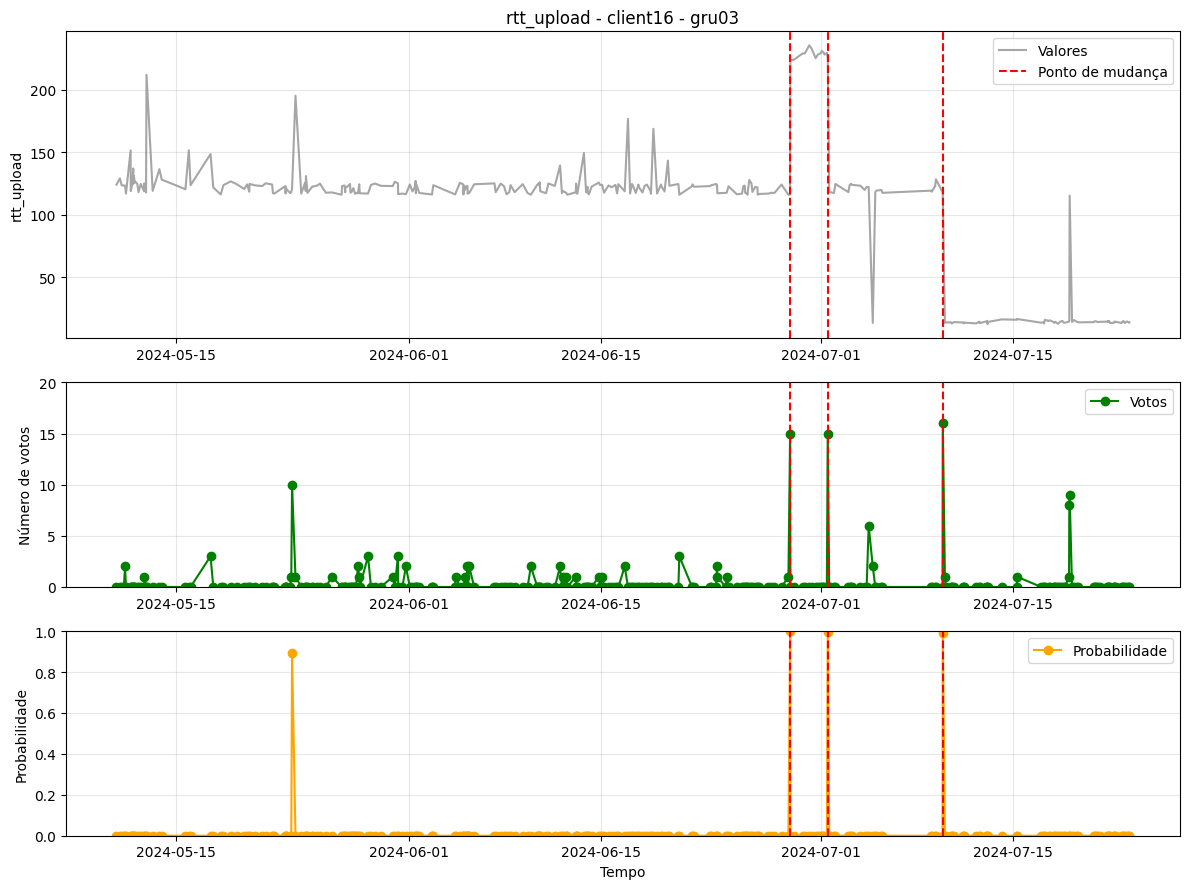

In [10]:
from visual_analysis import plot_changepoints

# Plotar a série com os pontos de mudança
client = 'client16'
site = 'gru03'
feature = 'rtt_upload'
plot_changepoints(data, client, site, feature, multivariate=False, plot_probs=True, plot_votes=True, save_fig=True)

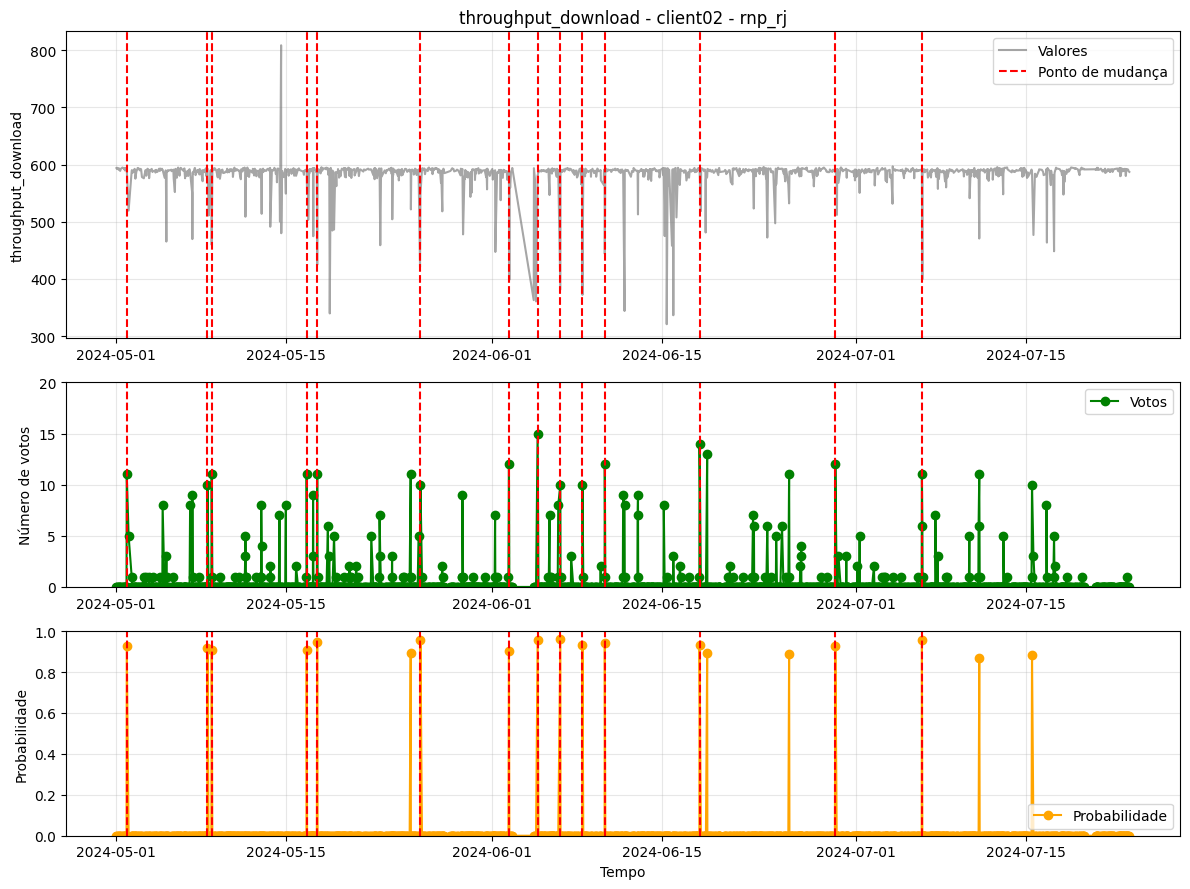

In [11]:
# Plotar série com os pontos de mudança
client = 'client02'
site = 'rnp_rj'
feature = 'throughput_download'
plot_changepoints(data, client, site, feature, multivariate=False, plot_probs=True, plot_votes=True)

# Criar um conjunto de dados de sobrevivência

In [12]:
from timeseries_processing import create_survival_dataset

df_surv = create_survival_dataset(data, 'throughput_download', max_gap_days=3, multivariate=False)
#df_surv = create_survival_dataset(data, 'rtt_download', max_gap_days=3, multivariate=False)

# Separar dados de entrada e de saída do modelo

In [13]:
# Criar lista com os nomes das colunas dummies iniciadas por 'client_' e 'site_'
client_cols = [col for col in df_surv.columns if col.startswith('client_')]
site_cols = [col for col in df_surv.columns if col.startswith('site_')]
onehot_cols = client_cols + site_cols

features = onehot_cols + ['throughput_download', 'throughput_upload', 'rtt_download', 'rtt_upload', 'throughput_download_std', 'throughput_upload_std', 'rtt_download_std', 'rtt_upload_std']
X = df_surv[features]
y = df_surv[['time', 'event']]

In [14]:
df_surv.columns

Index(['timestamp_start', 'timestamp_end', 'time', 'throughput_download',
       'rtt_download', 'throughput_upload', 'rtt_upload',
       'throughput_download_std', 'rtt_download_std', 'throughput_upload_std',
       'rtt_upload_std', 'event', 'client_client01', 'client_client02',
       'client_client03', 'client_client04', 'client_client05',
       'client_client06', 'client_client07', 'client_client08',
       'client_client09', 'client_client10', 'client_client11',
       'client_client12', 'client_client13', 'client_client14',
       'client_client15', 'client_client16', 'site_gru03', 'site_gru05',
       'site_gru06', 'site_rnp_rj', 'site_rnp_sp'],
      dtype='object')

# Pré-processamento dos dados de sobrevivência

In [15]:
from sklearn.preprocessing import StandardScaler

# Ajustar scaler aos dados de treinamento e aplicar aos conjuntos de treinamento, validação e teste
features_to_scale = ['throughput_download', 'throughput_upload', 'rtt_download', 'rtt_upload', 'throughput_download_std', 'throughput_upload_std', 'rtt_download_std', 'rtt_upload_std']

scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[features_to_scale] = scaler.fit_transform(X[features_to_scale])

In [16]:
from SurvMixClust_utils import y_array

db_ = df_surv.copy()

time_column = 'time'
event_column = 'event'

X = X_scaled[features].copy()
T = y[time_column].copy()
E = y[event_column].copy()
y = y_array(E, T)

# Treinar modelo SurvMixClust

In [17]:
from SurvMixClust import SurvMixClust

# Configuração dos hiperparâmetros do SurvMixClust
n_clusters = [2]        # Números de clusters a serem testados
n_fits = 20                # Número de ajustes do algoritmo EM
max_EM_interations = 100    # Número máximo de iterações do algoritmo EM para convergência
n_jobs = -1                # Número de processadores a serem utilizados

#model = SurvMixClust(n_clusters, n_fits, max_EM_interations, n_jobs)
#model.fit(X, y)

# Salvar o modelo em arquivo
#joblib.dump(model, 'survmixclust_uv_thr.pkl')

# Carregar o modelo de arquivo
model = joblib.load('survmixclust_uv_thr.pkl')

# Informações do modelo

In [18]:
model.score(X, y, metric='cindex')

0.7625676163000361

In [19]:
model.training_set_labels()

array([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1])

In [20]:
# labels = model.predict(X_test)

In [21]:
fig = model.plot_clusters()
# fig = model.plot_clusters(n_cluster=3, n_fit=0)

fig.show()

In [22]:
from SurvMixClust_utils import info_flat_from_info_list_K, best_model_keys_from_info_list_K

info_flat = info_flat_from_info_list_K(model.info_list_K)
best_model_keys = best_model_keys_from_info_list_K(model.info_list_K)
num_clusters_best = best_model_keys[0]

# Criar dataframe com os pesos de cada feature

In [23]:
# DataFrame associando as features aos seus coeficientes da regressão logística
logistic_coefficients = model.info['logit'].coef_

coefficients_df = pd.DataFrame({
    'feature': features,
    'coefficient': logistic_coefficients[0]
})

In [24]:
# Para ver as classes e sua ordem
print(model.info['logit'].classes_)  # Mostra [0, 1]

# Para ver os coeficientes
print(model.info['logit'].coef_)  # Mostra apenas os coeficientes para classe 1

[0 1]
[[ 0.74868253 -1.9978997   0.61701965  0.23134331  1.32890504 -1.0034583
  -1.53796052  0.30864955  0.00454278  0.04755667  0.78410841  0.08901268
  -0.93691891  0.73886919  0.54263484  0.03494075 -0.41972538  1.50701561
   1.89741113 -1.76176194 -1.22291143 -0.01495372  0.68588639 -1.59205498
  -0.61991697 -1.0413018   0.18597664 -0.33455627  0.90513464]]


In [25]:
coefficients_df.to_csv('coefficients_univariate.csv', index=False)

In [ ]:
coefficients_df

,feature,coefficient
0,client_client01,0.748683
1,client_client02,-1.997900
2,client_client03,0.617020
3,client_client04,0.231343
4,client_client05,1.328905
5,client_client06,-1.003458
6,client_client07,-1.537961
7,client_client08,0.308650
8,client_client09,0.004543
9,client_client10,0.047557


# Calcular a probabilidade de cada par pertencer a cada cluster

In [27]:
# Separar as colunas de cliente e site
client_columns = [col for col in df_surv.columns if col.startswith('client_')]
site_columns = [col for col in df_surv.columns if col.startswith('site_')]

# Identificar os pares cliente-site únicos
pairs = df_surv[client_columns + site_columns]

# Adicionar as métricas de interesse ao novo dataset
metrics = ['throughput_download', 'throughput_upload', 'rtt_download', 'rtt_upload', 'throughput_download_std', 'throughput_upload_std', 'rtt_download_std', 'rtt_upload_std']

# Agrupar os dados pelo par cliente-site e calcular a média das métricas
aggregated_data = df_surv.groupby(client_columns + site_columns)[metrics].mean().reset_index()

In [28]:
# Aplicar o scaler aos dados agregados
aggregated_data_scaled = aggregated_data.copy()
aggregated_data_scaled[metrics] = scaler.transform(aggregated_data[metrics])

In [29]:
# Certifique-se de que as colunas são consistentes e remova os nomes para compatibilidade
X_new = aggregated_data_scaled.values  # Converta para numpy array

# Prever as probabilidades usando o atributo logit
probabilities = model.logit.predict_proba(X_new)

# Cada linha em `probabilities` indica as probabilidades de pertencimento a cada cluster


In [30]:
# Adicionar as probabilidades ao dataframe agregado

aggregated_data['prob_cluster_0'] = probabilities[:, 0]
aggregated_data['prob_cluster_1'] = probabilities[:, 1]

# Criar o dataframe final com as colunas 'client', 'site', 'prob_cluster_0', 'prob_cluster_1'
final_df = aggregated_data[client_columns + site_columns + ['prob_cluster_0', 'prob_cluster_1']]

In [31]:
from process_results import decode_one_hot

# Decodificar os clientes
final_df = decode_one_hot(final_df, "client_")

# Decodificar os sites
final_df = decode_one_hot(final_df, "site_")

# Selecionar as colunas relevantes
df_final = final_df[['client', 'site', 'prob_cluster_0', 'prob_cluster_1']]

In [32]:
df_final[df_final['site'] == 'gru05']

,client,site,prob_cluster_0,prob_cluster_1
3,client16,gru05,0.017415,0.982585
10,client14,gru05,0.016444,0.983556
15,client13,gru05,0.100743,0.899257
20,client12,gru05,0.017059,0.982941
31,client09,gru05,0.010875,0.989125
36,client08,gru05,0.035031,0.964969
41,client07,gru05,0.040893,0.959107
46,client06,gru05,0.029647,0.970353
51,client05,gru05,0.007527,0.992473
60,client03,gru05,0.011784,0.988216


# Rotular séries temporais e dataset de sobrevivência

In [33]:
model.info['new_labels']

array([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1])

In [34]:
len(df_surv)

257

In [35]:
# Criar coluna com o cluster para cada intervalo no dataset de sobrevivência
df_surv_bkp = df_surv.copy()
df_surv['cluster'] = -1
df_surv.loc[:, 'cluster'] = model.info['new_labels']

# Criar colunas com a probabilidade de pertencimento a cada cluster
df_surv[[f'probability_cluster_{i}' for i in range(num_clusters_best)]] = -1

# Calcular as probabilidades de cada cluster e criar um DataFrame com as probabilidades
probs = model.logit.predict_proba(X)
df_probs = pd.DataFrame(probs, columns=[f'probability_cluster_{i}' for i in range(num_clusters_best)])

# Adicionar as probabilidades ao dataset de sobrevivência
df_surv.loc[:, df_probs.columns] = df_probs.values

# Obter as funções de sobrevivência para cada intervalo
surv_fcns = model.predict_surv_df(X)

In [36]:
from process_results import assign_labels

df_surv = assign_labels(df_surv, data, 'timestamp', surv_fcns, multivariate=False)

Clusters associados e séries temporais salvas em: datasets/ts_ndt_results/


In [37]:
from process_results import decode_one_hot

# Obter lista de pares de cada cluster
df_cluster_1 = df_surv[(df_surv['cluster'] == 1)]
df_cluster_0 = df_surv[(df_surv['cluster'] == 0)]

# Decodificar colunas de client e site
df_cluster_1 = decode_one_hot(df_cluster_1, 'client_')
df_cluster_1 = decode_one_hot(df_cluster_1, 'site_')
df_cluster_0 = decode_one_hot(df_cluster_0, 'client_')
df_cluster_0 = decode_one_hot(df_cluster_0, 'site_')

# Verificar quantos pares cliente-site únicos existem no cluster 1 e sua frequência
df_cluster_1_pairs = df_cluster_1.groupby(['client', 'site']).size().sort_values(ascending=False)
df_cluster_0_pairs = df_cluster_0.groupby(['client', 'site']).size().sort_values(ascending=False)

# Verificar quais pares cliente-site aparecem em ambos os clusters
pairs_both_clusters = df_cluster_1_pairs.index.intersection(df_cluster_0_pairs.index).to_list()
pairs_cluster_0 = df_cluster_0_pairs.index.to_list()
pairs_cluster_1 = df_cluster_1_pairs.index.to_list()

# Excluindo pares que aparecem em ambos os clusters
pairs_cluster_0 = [pair for pair in pairs_cluster_0 if pair not in pairs_both_clusters]
pairs_cluster_1 = [pair for pair in pairs_cluster_1 if pair not in pairs_both_clusters]

In [38]:
df_surv.to_csv('dataset_survival.csv', index=False)

# Análise visual

## Boxplots de cada métrica por cluster

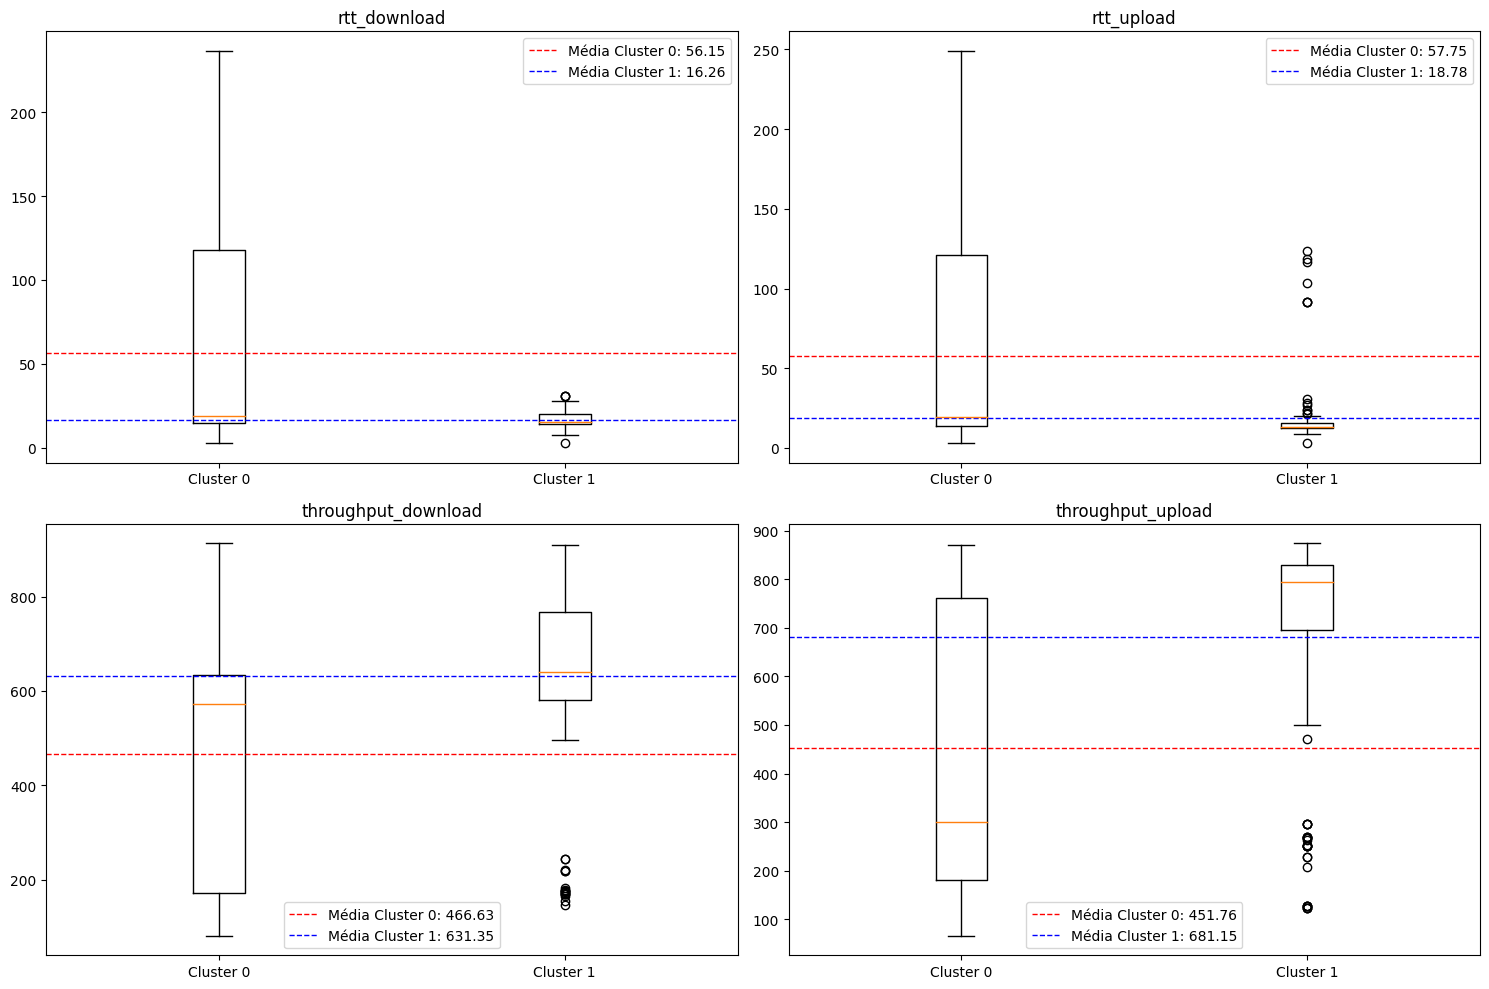

In [39]:
# Plotar boxplots de cada métrica para os clusters 0 e 1
plt.figure(figsize=(15, 10))

for i, feature in enumerate(['rtt_download', 'rtt_upload', 'throughput_download', 'throughput_upload']):
    plt.subplot(2, 2, i+1)
    plt.boxplot([df_cluster_0[feature], df_cluster_1[feature]])
    plt.xticks([1, 2], ['Cluster 0', 'Cluster 1'])
    plt.title(f'{feature}')
    
    # Adicionar linha de média para cada cluster
    mean_cluster_0 = df_cluster_0[feature].mean()
    mean_cluster_1 = df_cluster_1[feature].mean()
    plt.axhline(mean_cluster_0, color='red', linestyle='--', linewidth=1, label=f'Média Cluster 0: {mean_cluster_0:.2f}')
    plt.axhline(mean_cluster_1, color='blue', linestyle='--', linewidth=1, label=f'Média Cluster 1: {mean_cluster_1:.2f}')
    plt.legend()

plt.tight_layout()
plt.savefig('imgs/boxplots_clusters.png')
plt.show()

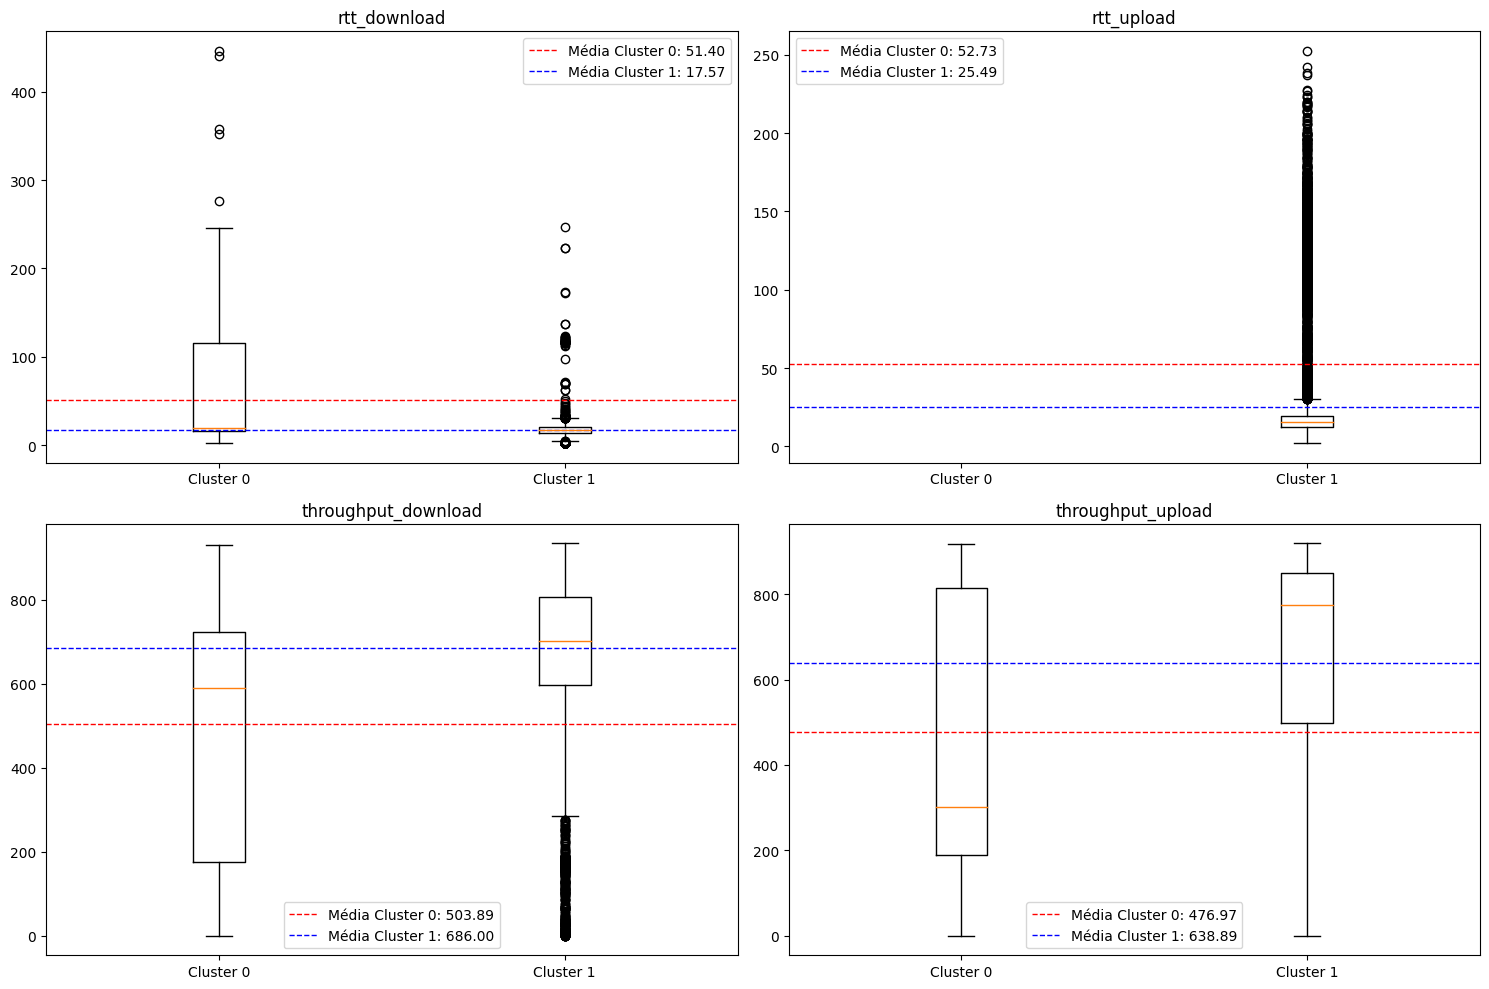

In [40]:
import glob

# Define the directory containing the Parquet files
directory = 'datasets/ts_ndt_results'

# Read all Parquet files in the directory and concatenate them into a single DataFrame
parquet_files = glob.glob(os.path.join(directory, "*.parquet"))
all_data = pd.concat([pd.read_parquet(file) for file in parquet_files], ignore_index=True)

all_data_cluster_0 = all_data[all_data['cluster'] == 0]
all_data_cluster_1 = all_data[all_data['cluster'] == 1]

# Plotar boxplots de cada métrica para os clusters 0 e 1
plt.figure(figsize=(15, 10))

for i, feature in enumerate(['rtt_download', 'rtt_upload', 'throughput_download', 'throughput_upload']):
    plt.subplot(2, 2, i+1)
    plt.boxplot([all_data_cluster_0[feature], all_data_cluster_1[feature]])
    plt.xticks([1, 2], ['Cluster 0', 'Cluster 1'])
    plt.title(f'{feature}')
    
    # Adicionar linha de média para cada cluster
    mean_cluster_0 = all_data_cluster_0[feature].mean()
    mean_cluster_1 = all_data_cluster_1[feature].mean()
    plt.axhline(mean_cluster_0, color='red', linestyle='--', linewidth=1, label=f'Média Cluster 0: {mean_cluster_0:.2f}')
    plt.axhline(mean_cluster_1, color='blue', linestyle='--', linewidth=1, label=f'Média Cluster 1: {mean_cluster_1:.2f}')
    plt.legend()

plt.tight_layout()
plt.show()

## Plotar os pares de cada cluster

In [41]:
from visual_analysis import plot_pairs

#plot_pairs(data, pairs_cluster_0, survival=True, local_mean=True, changepoints=True, plot_probs=False, plot_votes=False, multivariate=False, save_fig=True, filename='cluster_0_all_pairs', thr_max=1000)

In [42]:
#plot_pairs(data, pairs_cluster_1, survival=True, local_mean=True, changepoints=True, plot_probs=False, plot_votes=False, multivariate=False, save_fig=True, filename='cluster_1_all_pairs', thr_max=1000)

In [ ]:
len(pairs_cluster_1)

37

In [44]:
len(pairs_both_clusters)

26

In [45]:
#plot_pairs(data, pairs_both_clusters, survival=True, local_mean=True, changepoints=True, plot_probs=False, plot_votes=False, multivariate=False, save_fig=True, filename='both_clusters_all_pairs', thr_max=1000)

## Análise dos clientes de cada cluster

In [46]:
# Verificar clientes que só aparecem em um cluster
clients_cluster_0 = df_cluster_0['client'].unique()
clients_cluster_1 = df_cluster_1['client'].unique()

clients_only_cluster_0 = [client for client in clients_cluster_0 if client not in clients_cluster_1]
clients_only_cluster_1 = [client for client in clients_cluster_1 if client not in clients_cluster_0]
clients_both_clusters = [client for client in clients_cluster_0 if client not in clients_only_cluster_1]

In [47]:
clients_only_cluster_0

[]

In [48]:
clients_only_cluster_1

['client15']

In [49]:
clients_both_clusters

['client01',
 'client02',
 'client03',
 'client04',
 'client05',
 'client06',
 'client07',
 'client08',
 'client09',
 'client10',
 'client11',
 'client12',
 'client13',
 'client14',
 'client16']

In [50]:
# Verificar qual cliente de clients_both_clusters possui uma proporção maior de medições no cluster 0
proportions = {}
for client in clients_both_clusters:
    # Carregar todos os dados do cliente
    client_intervals = df_surv[df_surv[f'client_{client}'] == 1]

    # Somar a coluna 'time' para cada cluster
    time_cluster_0 = client_intervals[client_intervals['cluster'] == 0]['time'].sum()
    time_cluster_1 = client_intervals[client_intervals['cluster'] == 1]['time'].sum()
    proportion_cluster_0 = time_cluster_0 / (time_cluster_0 + time_cluster_1)
    proportions[client] = proportion_cluster_0

# Ordenar os clientes por proporção
proportions = {k: v for k, v in sorted(proportions.items(), key=lambda item: item[1], reverse=True)}

In [51]:
proportions

{'client07': 0.4974041121974401,
 'client06': 0.48783210432048685,
 'client02': 0.4109053523110393,
 'client10': 0.3876330447010084,
 'client13': 0.3704372088874269,
 'client11': 0.3322676892312374,
 'client08': 0.27477719353960256,
 'client12': 0.2744037230185484,
 'client09': 0.2692333663869997,
 'client03': 0.2044885043925635,
 'client14': 0.20367764121707413,
 'client16': 0.1793280531546223,
 'client01': 0.09893725917627112,
 'client05': 0.07576768047192507,
 'client04': 0.06675377594293416}

## Análise dos servidores de cada cluster

In [52]:
# Verificar clientes que só aparecem em um cluster
servers_cluster_0 = df_cluster_0['site'].unique()
servers_cluster_1 = df_cluster_1['site'].unique()

servers_only_cluster_0 = [server for server in servers_cluster_0 if server not in servers_cluster_1]
servers_only_cluster_1 = [server for server in servers_cluster_1 if server not in servers_cluster_0]
servers_both_clusters = [server for server in servers_cluster_0 if server not in servers_only_cluster_1]

In [53]:
servers_only_cluster_0

[]

In [54]:
servers_only_cluster_1

['gru05', 'gru06']

In [55]:
servers_both_clusters

['rnp_rj', 'rnp_sp', 'gru03']

In [56]:
# Verificar qual cliente de clients_both_clusters possui uma proporção maior de medições no cluster 0
proportions = {}
for server in servers_both_clusters:
    # Carregar todos os dados do cliente
    server_intervals = df_surv[df_surv[f'site_{server}'] == 1]

    # Somar a coluna 'time' para cada cluster
    time_cluster_0 = server_intervals[server_intervals['cluster'] == 0]['time'].sum()
    time_cluster_1 = server_intervals[server_intervals['cluster'] == 1]['time'].sum()
    proportion_cluster_0 = time_cluster_0 / (time_cluster_0 + time_cluster_1)
    proportions[server] = proportion_cluster_0

# Ordenar os clientes por proporção
proportions = {k: v for k, v in sorted(proportions.items(), key=lambda item: item[1], reverse=True)}

In [57]:
proportions

{'gru03': 0.6449702343394013,
 'rnp_rj': 0.4024661865819499,
 'rnp_sp': 0.2045970169764993}

## Calcular a proporção de tempo em cada cluster para cada cliente e cada servidor

In [58]:
from process_results import calculate_cluster_proportions

client_table, site_table = calculate_cluster_proportions(df_surv)

In [59]:
client_table.to_csv('cluster_proportions_clients.csv', index=True)
site_table.to_csv('cluster_proportions_servers.csv', index=True)

## Gráfico de pares de exemplo

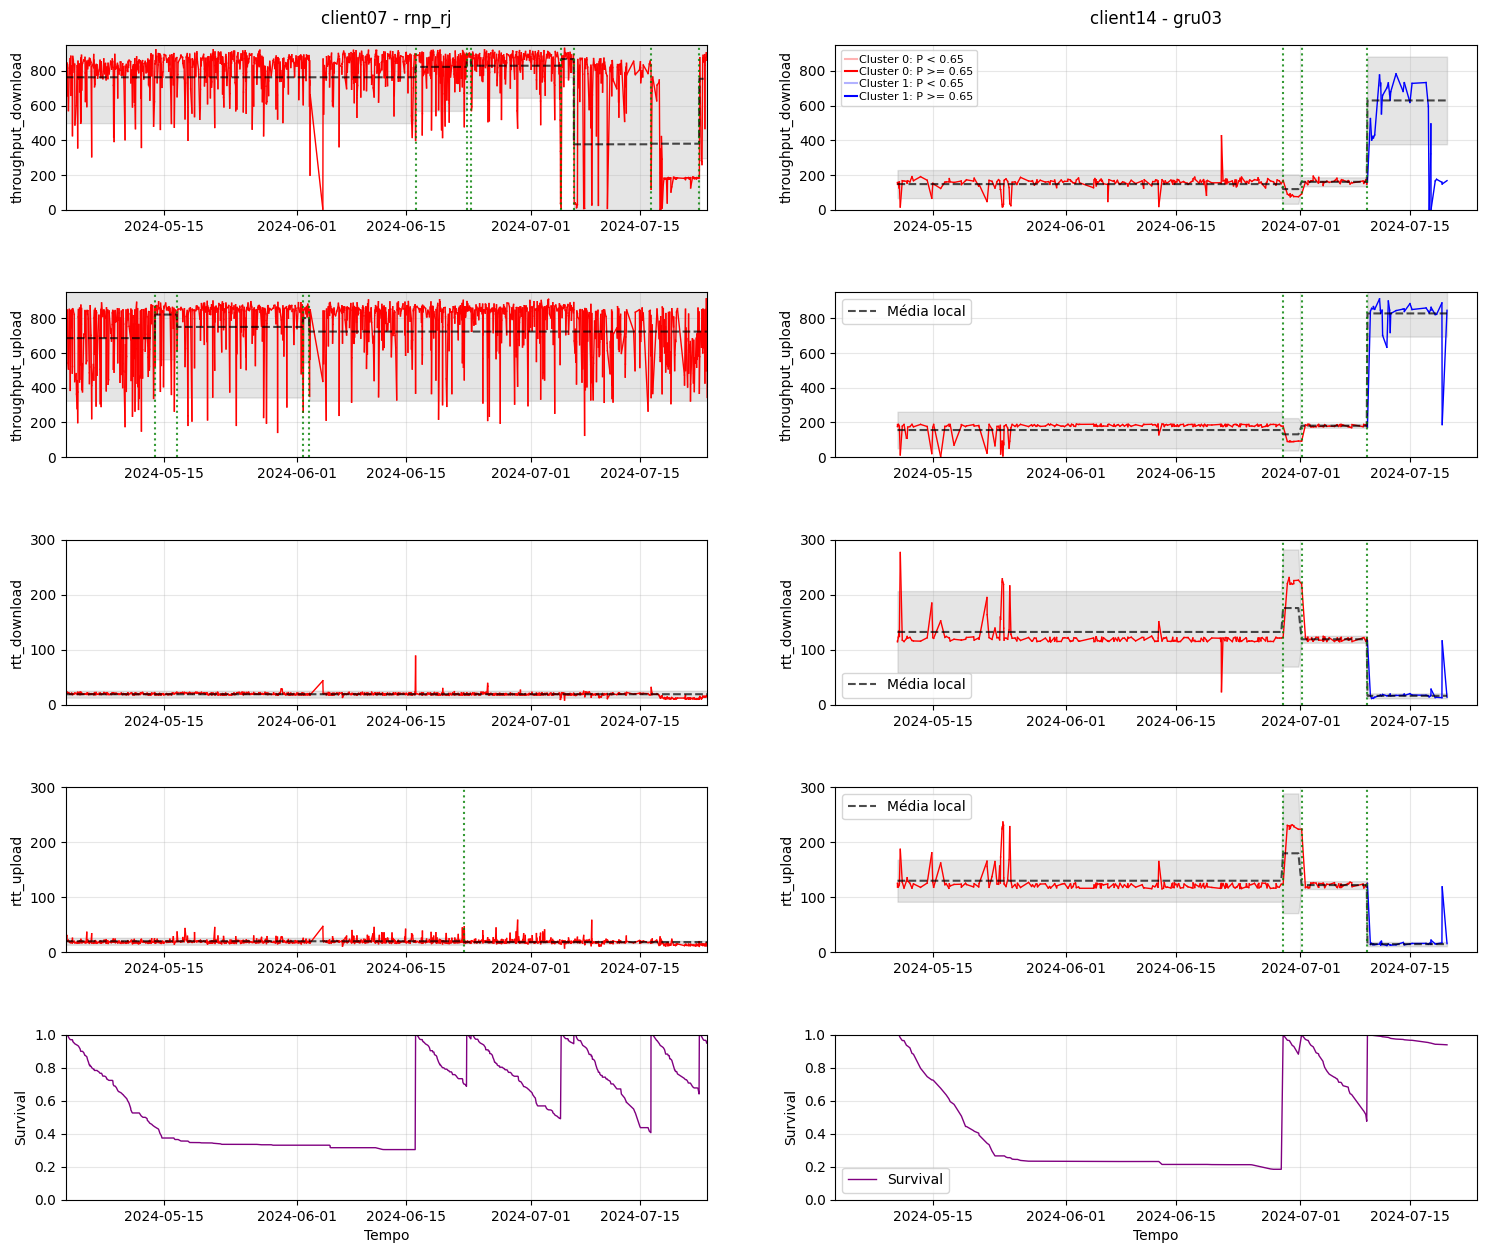

In [79]:
from visual_analysis import plot_pairs

pairs = [('client07', 'rnp_rj'),
         ('client14', 'gru03')]

plot_pairs(data, pairs, survival=True, local_mean=True, changepoints=True, multivariate=False, plot_probs=False, plot_votes=False, rtt_max=300, thr_max=950)

## Gráficos analisando o decremento da variável pelo número de pontos de mudança

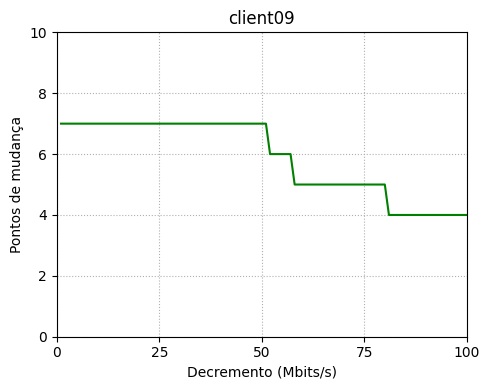

In [61]:
from visual_analysis import plot_decrement

clients = ['client09']
plot_decrement(clients, 'throughput_download', decrement=True, multivariate=False)

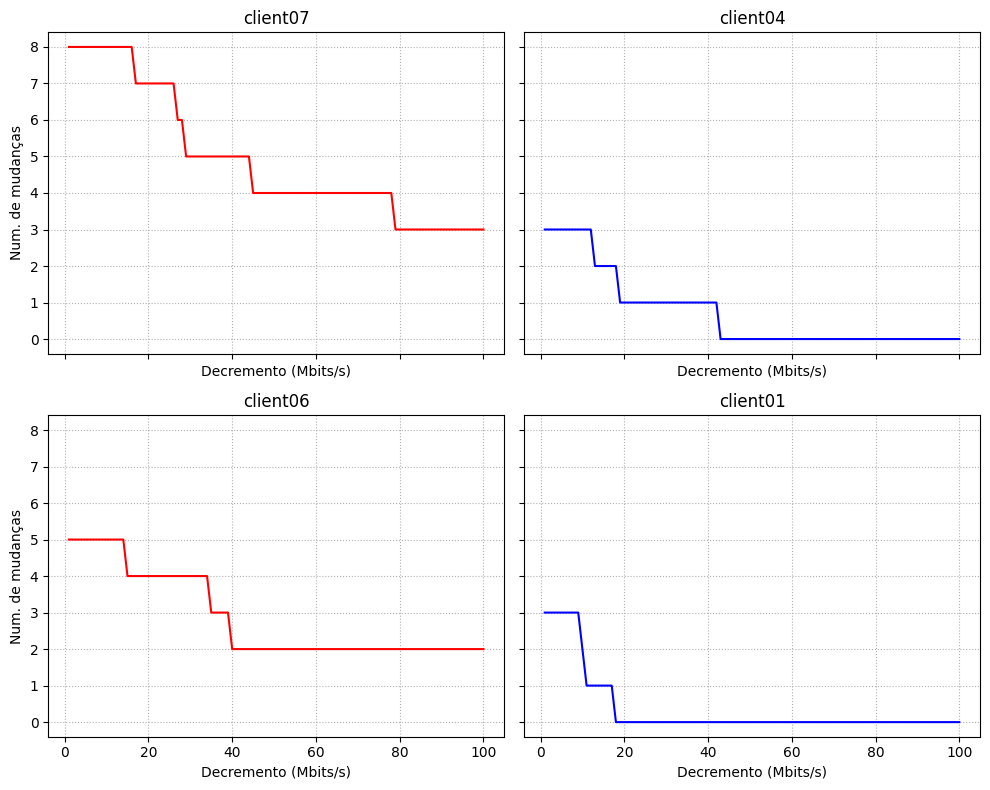

In [62]:
from visual_analysis import plot_decrement_dual

clients_0 = ['client07', 'client06']
clients_1 = ['client04', 'client01']

plot_decrement_dual(clients_0, clients_1, 'throughput_download', decrement=True , multivariate=False)